### RatK Day2NSD recording info

In [1]:
import numpy as np
import subjects

sess = subjects.nsd.ratKday2[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



### Set probe configuration
- RatK_Day2NSD had 128chans-8shank diagnostic biochip

In [ ]:
%matplotlib widget
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(8):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0,-15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

# prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(sess.filePrefix.with_suffix('.probegroup.npy'))
plot_probe(prbgrp)



In [ ]:
from neuropy.utils import probe_util

probe_util.write_spyking_circus(
    sess.filePrefix.with_suffix(".prb"),
    sess.probegroup,
    rmv_badchans=True,
    combine_shanks=True,
)


### Create epochs for your experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [ ]:
%matplotlib widget
from neuropy import plotting

fig = plotting.Fig(grid=(2,4),size=(8.5,5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x,maze_pos.y)

ax = fig.subplot(fig.gs[0,1:])
ax.plot(maze_pos.time,maze_pos.x,'r')
ax.plot(maze_pos.time,maze_pos.y,'g')
ax.plot(linear_pos.time,linear_pos.x,'k')

In [ ]:
sess.paradigm.to_dataframe()

In [5]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 10792, 14239],
        "stop": [10776, 13900, 51972],
        "label": ["pre", "maze", "post"],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.save(sess.filePrefix.with_suffix(".paradigm.npy"))


/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.paradigm.npy saved


### Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

#### Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
pbe.filename = sess.filePrefix.with_suffix(".pbe")
plotting.plot_artifact_epochs(artifact_epochs, signal)


#### Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
pbe.filename = sess.filePrefix.with_suffix(".pbe")
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

### Importing spiketrains from Phy

In [2]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

# cluster_path = Path(
#     "/data/Clustering/sessions/RatK/Day2/spykcirc/RatK_Day2_2019-08-08_04-00-00/RatK_Day2_2019-08-08_04-00-00.GUI"
# )
cluster_path = Path(
    "/home/bapung/Documents/ClusteringHub/spykcirc/RatK/RatKDay2NSD/RatK_Day2_2019-08-08_04-00-00-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains = phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id < 4] = "pyr"
neuron_type[neuron_type_id == 6] = "mua"
neuron_type[neuron_type_id == 8] = "inter"


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms, dtype="object"),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=neuron_type,
)

neurons.save(sess.filePrefix.with_suffix(".neurons"))


/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.neurons saved


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

### BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
# plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()

### Assign position data

- For RatKDay2NSD no frames were deleted from .dat file (Cross checked on 19Jan2022)

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder,scale_factor=0.25)

In [ ]:
import pandas as pd
from datetime import datetime

# ------- maze align corection ---------
t_error = [0, 0.51]

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    # sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(
        t_error[i], unit="sec"
    )
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)


x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=opti_data.sampling_rate)
position.save(sess.filePrefix.with_suffix(".position.npy"))


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(position.x,position.y)

### Linearize position

In [2]:
from neuropy.utils import position_util

maze = sess.paradigm['maze'].flatten()
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)
linear_pos.save(sess.filePrefix.with_suffix('.maze.linear'))

/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:328: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.maze.linear saved


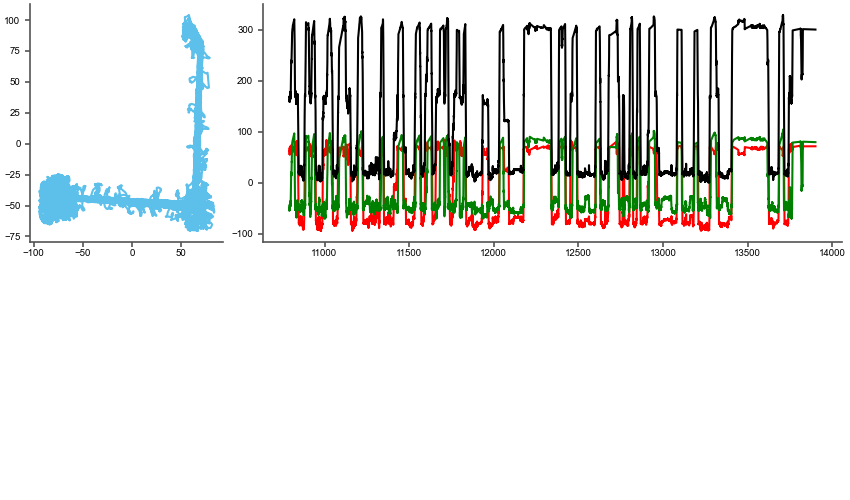

In [3]:
from neuropy import plotting

fig = plotting.Fig(grid=(2,4),size=(8.5,5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x,maze_pos.y)

ax = fig.subplot(fig.gs[0,1:])
ax.plot(maze_pos.time,maze_pos.x,'r')
ax.plot(maze_pos.time,maze_pos.y,'g')
ax.plot(linear_pos.time,linear_pos.x,'k')